# Demonstration of Supervised Classification

Predicting survival for individual passengers on titanic dataset.


**Data Sources:**

- `titanic_full.csv`: Dataset for all 1310 passengers

**Project history**

- Created Aug 29th 2019, for demo purpose only


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Check-data" data-toc-modified-id="Check-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check data</a></span></li><li><span><a href="#...-but-now-split-into-train-and-test-sets!" data-toc-modified-id="...-but-now-split-into-train-and-test-sets!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>... but now split into train and test sets!</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare data</a></span><ul class="toc-item"><li><span><a href="#Continue-with-imputation-of-missing-values" data-toc-modified-id="Continue-with-imputation-of-missing-values-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Continue with imputation of missing values</a></span></li><li><span><a href="#Encode-categorical-data" data-toc-modified-id="Encode-categorical-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Encode categorical data</a></span></li></ul></li><li><span><a href="#Before-we-proceed-...-Let's-calculate-a-naive-baseline-model!" data-toc-modified-id="Before-we-proceed-...-Let's-calculate-a-naive-baseline-model!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Before we proceed ... Let's calculate a naive baseline model!</a></span></li><li><span><a href="#Train-and-evaluate-a-a-linear-classifier-model-(Logistic-Regression)" data-toc-modified-id="Train-and-evaluate-a-a-linear-classifier-model-(Logistic-Regression)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train and evaluate a a linear classifier model (Logistic Regression)</a></span></li><li><span><a href="#Train-and-evaluate-a-decision-tree-based-model-(Gradient-Boosting)" data-toc-modified-id="Train-and-evaluate-a-decision-tree-based-model-(Gradient-Boosting)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train and evaluate a decision tree based model (Gradient Boosting)</a></span></li><li><span><a href="#Predict-survival-probability-for-a-new-instance" data-toc-modified-id="Predict-survival-probability-for-a-new-instance-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Predict survival probability for a new instance</a></span></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, \
        precision_score, recall_score, confusion_matrix, classification_report
from sklearn.externals import joblib

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Load data
data_original = pd.read_csv("data/titanic_full.csv", delimiter=';')

## Check data 

In [3]:
data_original.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


- pclass: Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
- survival: A Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes); this is our target
- name: A field rich in information as it contains title and family names
- sex: male/female
- age: Age
- sibsp: Number of siblings/spouses aboard
- parch: Number of parents/children aboard
- ticket: Ticket number.
- fare: Passenger fare (British Pound).
- cabin: Cabin ID
- embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- home.dest: Home/destination

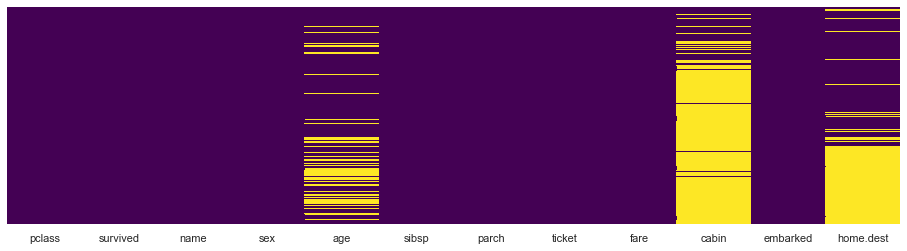

In [4]:
# Check for missing data
plt.figure(figsize=(16,4))
sns.heatmap(data_original.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [5]:
def list_NaN(df):
    """Display DataFrame with missing values and their respective percentage
    for every column that contains missing values.

    Arguments:
    ----------
    - df: DataFrame

    Returns:
    --------
    - None, display DataFrame
    """
    if df.isnull().sum().sum() > 0:
        total = df.isnull().sum()
        percent = round(df.isnull().sum() / len(df) * 100, 1)
        dtypes = df.dtypes

        missing_data = pd.concat([total, percent, dtypes], axis=1,
                                 keys=['total', 'percent', 'dtype'])
        missing_data = missing_data.loc[missing_data['total'] != 0 \
                ].sort_values(['total'], ascending=False)
        display(missing_data)
    else:
        print("No empty cells in DataFrame.")
        
list_NaN(data_original)

,total,percent,dtype
cabin,1014,77.5,object
home.dest,564,43.1,object
age,263,20.1,float64
embarked,2,0.2,object
fare,1,0.1,float64


**Decision concerning missing values:** 
- Drop columns ['cabin', 'home.dest']
- Impute mean fare value for respective class
- Impute embarked mode
- Impute stratified mean age for gender and class

**And let's also drop the names and ticket columns for simplicity's sake**

In [6]:
# Drop 4 columns
data = data_original.drop(['cabin', 'home.dest', 'name', 'ticket'], axis=1)
assert data.shape[1] == data_original.shape[1]-4

## ... but now split into train and test sets!

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('survived', axis=1), 
                                                    data['survived'], 
                                                    test_size=0.20, 
                                                    random_state=101)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1047, 7)
y_train: (1047,)
X_test: (262, 7)
y_test: (262,)


## Prepare data

In [8]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked
1218,3,male,30.0,0,0,8.0500,S
1060,3,female,18.0,0,0,7.7750,S
24,1,female,29.0,0,0,221.7792,S
840,3,female,24.0,0,0,8.8500,S
816,3,male,NaN,0,0,7.8958,C


### Continue with imputation of missing values

In [9]:
# Impute age
# Look at mean ages for different passenger groups
mean_ages = pd.DataFrame(X_train.groupby(['sex', 'pclass'])['age'].mean().round(0))
display(mean_ages)

age
sex    pclass      
female 1       37.0
       2       27.0
       3       22.0
male   1       41.0
       2       31.0
       3       26.0

In [10]:
def impute_age(cols):
    """Das müsste auch etwas eleganter gehen ..."""
    
    age = cols[0]
    pclass = cols[1]
    sex = cols[2]
    
    if pd.isnull(age):
        if pclass == 1:
            if sex == 'female':
                return mean_ages['age'][0]   
            else:
                return mean_ages['age'][3]
        elif pclass == 2:
            if sex == 'female':
                return mean_ages['age'][1]
            else:
                return mean_ages['age'][4]
        else:
            if sex == 'female':
                return mean_ages['age'][2]
            else:
                return mean_ages['age'][5]
    else:
        return age
    
X_train['age'] = X_train[['age','pclass', 'sex']].apply(impute_age,axis=1)
assert X_train['age'].isnull().sum() == 0

In [11]:
# Impute embarked
embarked_mode = X_train['embarked'].value_counts().index[0]
X_train['embarked'] = X_train['embarked'].fillna(value=embarked_mode)
assert X_train['embarked'].isnull().sum() == 0

In [12]:
# Impute fare
mean_fares = pd.DataFrame(X_train.groupby(['pclass'])['fare'].mean())
display(mean_fares)

,fare
pclass,
1,87.743111
2,21.152250
3,13.270321


In [13]:
def impute_fare(cols):
    """Das müsste auch etwas eleganter gehen ..."""
    
    fare = cols[0]
    pclass = cols[1]
    
    if pd.isnull(fare):
        if pclass == 1:
            return mean_fares['fare'][0]  
        elif pclass == 2:
            return mean_fares['fare'][1]
        else:
            return mean_fares['fare'][2]
    else:
        return fare
    
X_train['fare'] = X_train[['fare','pclass']].apply(impute_fare,axis=1)
assert X_train['fare'].isnull().sum() == 0

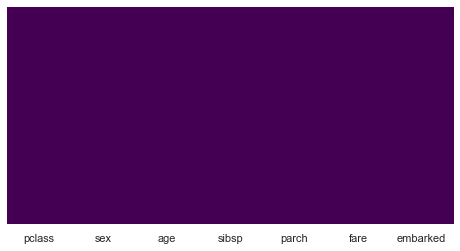

In [14]:
# Display data, to show that missing values are removed
plt.figure(figsize=(8,4))
sns.heatmap(X_train.isnull(),yticklabels=False,cbar=False,cmap='viridis');

### Encode categorical data 

Most algorithms cannot handle non-numeric data

In [15]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked
1218,3,male,30.0,0,0,8.0500,S
1060,3,female,18.0,0,0,7.7750,S
24,1,female,29.0,0,0,221.7792,S
840,3,female,24.0,0,0,8.8500,S
816,3,male,26.0,0,0,7.8958,C


In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 1218 to 863
Data columns (total 7 columns):
pclass      1047 non-null int64
sex         1047 non-null object
age         1047 non-null float64
sibsp       1047 non-null int64
parch       1047 non-null int64
fare        1047 non-null float64
embarked    1047 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 65.4+ KB


In [17]:
# add pclass to categorical columns (dtype= 'object')
X_train['pclass'] = X_train['pclass'].astype('object')

In [18]:
def encode_cat_cols(df):
    df_ohe = df.copy()
    for col in df_ohe.select_dtypes(include=['object', 'category']).columns:
        df_ohe = pd.concat([df_ohe.drop(col, axis=1), 
                           pd.get_dummies(df_ohe[col], prefix=col, prefix_sep='_',
                                          drop_first=True, dummy_na=False)], 
                                          axis=1)
    return df_ohe

X_train = encode_cat_cols(X_train)
display(X_train.head())

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
1218,30.0,0,0,8.0500,0,1,1,0,1
1060,18.0,0,0,7.7750,0,1,0,0,1
24,29.0,0,0,221.7792,0,0,0,0,1
840,24.0,0,0,8.8500,0,1,0,0,1
816,26.0,0,0,7.8958,0,1,1,0,0


In [19]:
# Apply all pre-processing to X_test too (copy-paste)
X_test['age'] = X_test[['age','pclass', 'sex']].apply(impute_age,axis=1)
X_test['embarked'] = X_test['embarked'].fillna(value=embarked_mode)
X_test['fare'] = X_test[['fare','pclass']].apply(impute_fare,axis=1)
X_test['pclass'] = X_test['pclass'].astype('object')
X_test = encode_cat_cols(X_test)
assert X_test.isnull().sum().sum() == 0
assert X_test.shape[1] == X_train.shape[1]

## Before we proceed ... Let's calculate a naive baseline model!

In [20]:
np.random.seed(666)
naive_guess = np.random.binomial(1, p=np.mean(y_train),
                                 size=len(y_test))

print("Percentage of positive class in training data is:",
      round(np.mean(y_train), 4))

# Print ROC-AUC curve
print("ROC AUC score:", roc_auc_score(y_test,
      np.repeat(np.mean(y_train), len(y_test))))

Percentage of positive class in training data is: 0.3754
ROC AUC score: 0.5


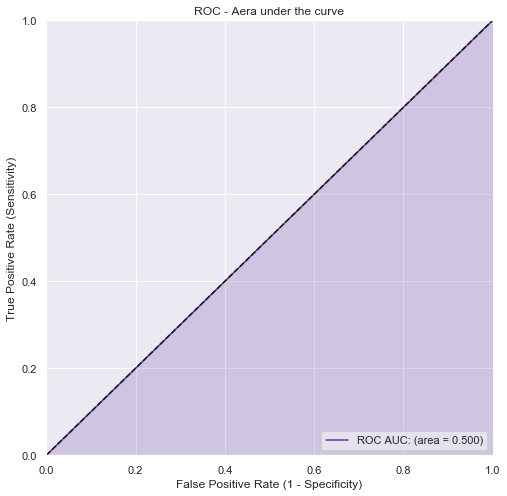

In [21]:
def plot_ROC_curve(y_test, test_probs):
    """Plot area under the ROC-curve (ROC-AUC)."""

    # Calculate AUC-score and ROC-curve
    auc = roc_auc_score(y_test, test_probs)
    fpr, tpr, thresholds = roc_curve(y_test, test_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label="{} (area = {:.3f})".format("ROC AUC:",
             auc), color=color)
    plt.fill_between(fpr, tpr, alpha=0.2, color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)', size=12)
    plt.ylabel('True Positive Rate (Sensitivity)', size=12)
    plt.title('ROC - Aera under the curve', size=12)
    plt.legend(loc='lower right');
    
plot_ROC_curve(y_test, np.repeat(np.mean(y_train), len(y_test)))

## Train and evaluate a a linear classifier model (Logistic Regression)

In [22]:
# Instantiate model and fit on train data
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train, y_train)

# Get predictions and probablities for the predictions
predictions_log = logmodel.predict(X_test)
probabilities_log_full = logmodel.predict_proba(X_test)
probabilities_log = probabilities_log_full[:, 1]

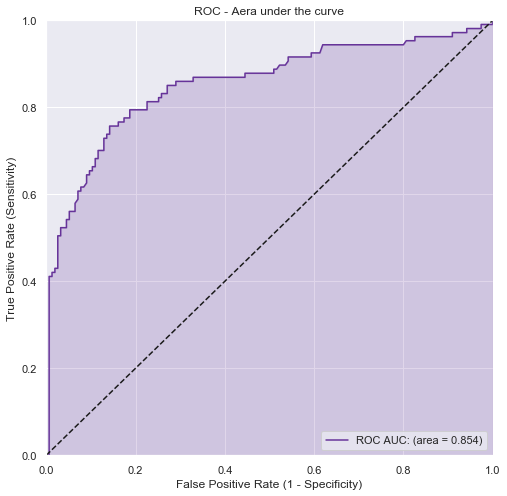

In [23]:
plot_ROC_curve(y_test, probabilities_log)

## Train and evaluate a decision tree based model (Gradient Boosting)

In [24]:
# Instantiate model and fit on train data
gbcmodel = GradientBoostingClassifier(n_estimators=100)
gbcmodel.fit(X_train, y_train)

# Get predictions and probablities for the predictions
predictions_gbc = gbcmodel.predict(X_test)
probabilities_gbc_full = gbcmodel.predict_proba(X_test)
probabilities_gbc = probabilities_gbc_full[:, 1]

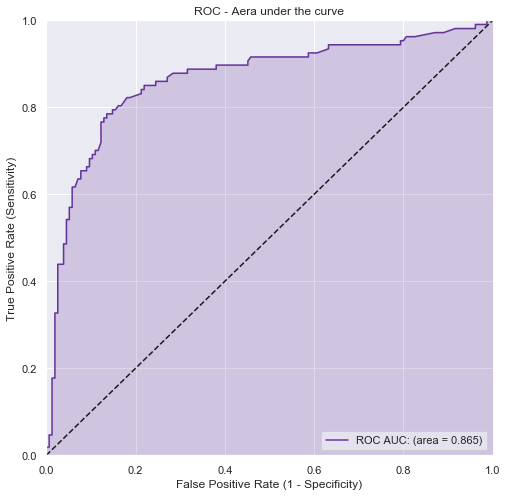

In [25]:
plot_ROC_curve(y_test, probabilities_gbc)

In [26]:
def plot_confusion_matrix(y_test, test_preds):
    """Plot confusion matrix and print detailed metrics for evaluated
    model."""

    conf_matrix = confusion_matrix(y_test, test_preds)
    tn, fp, fn, tp = conf_matrix.ravel()

    label_names = np.sort(y_train.unique())
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d',
                cbar=False, xticklabels=label_names,
                yticklabels=label_names)
    plt.ylim([0,2])
    plt.xlabel('true label')
    plt.ylabel('predicted label')

    for value, name in {tp: "True positives",
                        fp: "False positives",
                        tn: "True negatives",
                        fn: "False negatives",
                        }.items():
        print("{}: {} ({:.2f}%)".format(name, value,
                                        value / conf_matrix.sum() * 100))
    print("\nProportion of misclassified instances in total:",
          round((fp+fn) / (tp+fp+tn+fn), 2))
    print("Typ I error (Number of items wrongly identified as " +
          "positive out of total true negatives):", round(fp/(tn+fp), 2))
    print("Type II error (Number of items wrongly identified as " +
          "negative out of total true positives):", round(fn/(tp+fn), 2))

True positives: 74 (28.24%)
False positives: 17 (6.49%)
True negatives: 138 (52.67%)
False negatives: 33 (12.60%)

Proportion of misclassified instances in total: 0.19
Typ I error (Number of items wrongly identified as positive out of total true negatives): 0.11
Type II error (Number of items wrongly identified as negative out of total true positives): 0.31


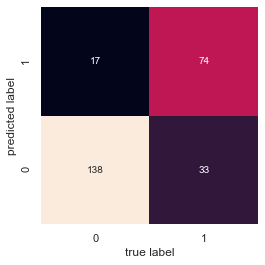

In [27]:
plot_confusion_matrix(y_test, predictions_gbc)

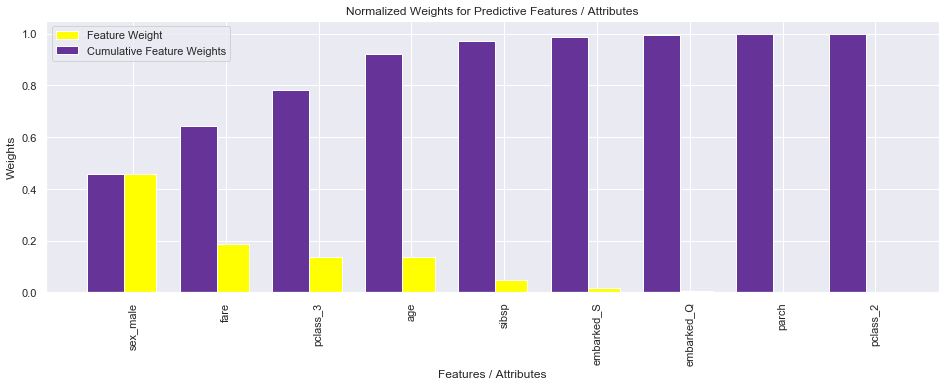

In [28]:
def plot_feature_weights(feature_importances, max_cols=None):

    weights = feature_importances
    weights_named_df = pd.DataFrame(sorted(zip(weights,
                                                     X_train.columns),
                                          reverse=True))

    if max_cols is not None:
        weights_named_df = weights_named_df.iloc[:, :max_cols]
    else:
        plt.figure(figsize=(16, 5))
        plt.bar(np.arange(len(weights_named_df)),
                weights_named_df[0],
                width=0.5,
                align="center",
                color='yellow',
                label="Feature Weight")
        plt.bar(np.arange(len(weights_named_df)) - 0.3,
                np.cumsum(weights_named_df[0]),
                width=0.4,
                align="center",
                color=color,
                label="Cumulative Feature Weights")
        plt.title("Normalized Weights for Predictive Features / Attributes")
        plt.ylabel("Weights")
        plt.xlabel("Features / Attributes")
        plt.xticks(np.arange(len(weights_named_df)),
                   weights_named_df[1],
                   rotation=90)
        plt.legend(loc='upper left');
        

importances_gbc = gbcmodel.feature_importances_
plot_feature_weights(importances_gbc)

In [29]:
### Save model 
dump_location = "gbc_titanic.joblib.dat"
joblib.dump(gbcmodel, dump_location) 
print("Saved model to:", dump_location)

Saved model to: gbc_titanic.joblib.dat


## Predict survival probability for a new instance

In [30]:
# Print model with its hyperparameters
print(gbcmodel)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [31]:
X_train.head()

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
1218,30.0,0,0,8.0500,0,1,1,0,1
1060,18.0,0,0,7.7750,0,1,0,0,1
24,29.0,0,0,221.7792,0,0,0,0,1
840,24.0,0,0,8.8500,0,1,0,0,1
816,26.0,0,0,7.8958,0,1,1,0,0


In [32]:
raph_dict = {'age': 41,
             'sibsp': 1,
             'parch': 2,
             'fare': mean_fares['fare'][1],
             'pclass_2': 1,
             'pclass_3': 0,
             'sex_male': 1,
             'embarked_Q': 0,
             'embarked_S': 0,
             }

raph = np.array([val for val in raph_dict.values()]).reshape(1, -1)

print("Survival Prediction:", gbcmodel.predict(raph))
print("Survival Probability:", gbcmodel.predict_proba(raph)[:, 1])

Survival Prediction: [0]
Survival Probability: [0.31173907]


In [33]:
ismael_dict = {'age': 3, # only change
             'sibsp': 1,
             'parch': 2,
             'fare': mean_fares['fare'][1],
             'pclass_2': 1,
             'pclass_3': 0,
             'sex_male': 1,
             'embarked_Q': 0,
             'embarked_S': 0,
             }

ismael = np.array([val for val in ismael_dict.values()]).reshape(1, -1)

print("Survival Prediction:", gbcmodel.predict(ismael))
print("Survival Probability:", gbcmodel.predict_proba(ismael)[:, 1])

Survival Prediction: [1]
Survival Probability: [0.94514832]


---